<a href="https://colab.research.google.com/github/allo82/personal-website/blob/main/15_688_Tutorial_Allison_Lo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction** 

This tutorial will introduce you to web scraping using Selenium. Once the data is collected, we will analyze and visualize the data using different techniques. 

**Tutorial content**
<br>
In this tutorial, we will show how to scrape job postings from Indeed.com using [Selenium](https://selenium-python.readthedocs.io/). We will be looking for software engineering internships in the United States. After the data is collected, we will export the data to a CSV file, plot the geographic distribution of the jobs in a bar chart, and use a wordcloud to visualize the frequently occurring words contained in job descriptions. 




# **Installing the libraries**

Before getting started, you will need to install the libraries used in this tutorial. We will use Selenium to scrape job postings from Indeed and `us` to map state abbreviations to state names. 




In [ ]:
!pip install selenium
!pip install us
!apt-get update
!apt install chromium-chromedriver

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

Selenium automates web browser interaction from Python. It needs a driver to interact with the browser. Here, we will use ChromeDriver to interact with Chrome. There are other drivers available for Edge, Firefox, Safari, etc. 


First, make sure the following commands work for you:

In [ ]:
from selenium import webdriver
#Include these options for WebDriver to work with Colab. 
#Source: https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com
#For more information, see "More on ChromeDriver" at the bottom of the page.
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
#the following are used to create explicit waits - see below for details 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

# **Scraping data using Selenium**

**Objective**
<br>
Our objective is to scrape Indeed for job postings using the Advanced Job Search filter (which is accessible after first clicking the "Find jobs" button on the homepage. "Advanced Job Search" appears to the right of the "Find jobs" button on this next page. We will look for "software engineer" jobs with the following criteria:
- job type: internship
- location: United States
- jobs published: within 7 days
- display: 50 results per page 


# Defining search parameters
**Initializing the WebDriver**
<br>
We will be referencing the code listed in the cell a few cells below this current cell. We will first create an instance of the Chrome WebDriver, defined in `driver`. We pass in the options that we previously defined.

We can open Indeed by passing in the url to `driver.get`. 

An implicit wait tells the WebDriver to wait for a certain period of time (here 5 seconds) before throwing an exception if an element is not immediately found. The default is 0. Check out Reference #6 for more information.



```
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

#Open webpage
driver.get('https://indeed.com')

driver.implicitly_wait(5) #5 seconds
```



**Locating elements**
<br>
XPath (XML Path Language) is used to locate nodes in an XML document. Since XML includes HTML, we can use `find_element_by_xpath` to search for elements in a web application. Use Developer Tools in Chrome to identify which elements to use. In addition to XPath, there are other ways to locate elements in a page. Check out Reference #5 for more information.

Here are some definitions of the path expressions used in the code, as given by https://www.w3schools.com/xml/xpath_syntax.asp. Note that the definition follows the corresponding expression. 
- **expression**: /  
- definition: select from the root node

- **expression**: //  
- definition: select nodes starting from the current node that are anywhere in the document and match the selection

- **expression**: //*  
- definition: select all elements in the document

- **expression**: .   
- definition: select the current node 

_Example path expressions_: 
- `//input[@id="where"]` - select all `input` elements that have an `id` attribute with a value of "where". 
- `//*[@class="icl-WhatWhere-buttonWrapper"]/button` - select all `button` elements that are children of the elements that have a `class` attribute with a value of "icl-WhatWherebuttonWrapper" 
- `select[@id="limit"]//option[@value="50"]` - select all `option` elements with a `value` attribute of "50" that are descendants of the `select` element which has an `id` attribute with a value of "limit", no matter where the `option` elements are located under the `select` element 

Once we locate the desired elements, where for example, `element = driver.find_element_by_xpath('//input[@id="where"]')`, we can use `element.click()` to click on `element`. In the code shown below, `element` will be either a dropdown menu or a button. 

To enter text in an input field element, first use `element.clear()` to clear the input field. Then we can use `element.send_keys("include text here")` to enter text in the input field (this is similar to typing on a keyboard). 

In [ ]:
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

#Open webpage
driver.get('https://indeed.com')

driver.implicitly_wait(5) #5 seconds

#Click the search jobs button on Indeed homepage
find_jobs = driver.find_element_by_xpath(
    '//*[@class="icl-WhatWhere-buttonWrapper"]/button')
find_jobs.click()

#Advanced search for jobs - set filters here
advanced_search = driver.find_element_by_xpath(
    '//*[@class="sl"]').get_attribute('href')
driver.get(advanced_search)

#Search for jobs with the keywords "software engineer"
search_term = driver.find_element_by_xpath('//input[@id="as_and"]')
search_term.clear()
search_term.send_keys("software engineer")

#Search for job type - internship
job_type = driver.find_element_by_xpath(
    '//select[@id="jt"]//option[@value="internship"]')
job_type.click() 

#Search within 0 miles of the specified location
location = driver.find_element_by_xpath(
    '//select[@id="radius"]//option[@value="0"]')
location.click()

#Specify the location as the United States - clear the default value 
#based on where the user is located 
locale = driver.find_element_by_xpath('//input[@id="where"]')
locale.clear()
locale.send_keys("United States")

#Search for jobs posted within the last 7 days
date_jobs_published = driver.find_element_by_xpath(
    '//select[@id="fromage"]//option[@value="7"]')
date_jobs_published.click()

#Display 50 results per page 
results_per_page = driver.find_element_by_xpath(
    '//select[@id="limit"]//option[@value="50"]')
results_per_page.click() 

#Click the "search jobs" button
submit = driver.find_element_by_xpath('//*[@id="fj"]')
submit.click()

#A popup to activate notifications from Indeed may appear. First, wait 
#for this popup to become clickable. Then close the popup. 
wait = WebDriverWait(driver, 10) #wait for 10 seconds
close_popup = wait.until(EC.element_to_be_clickable((By.ID,"popover-x")))
close_popup.click()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: use options instead of chrome_options
  """Entry point for launching an IPython kernel.


Once the advanced search inputs are filled out, and the "Search jobs" button is clicked, a popup to activate notifications from Indeed may appear. We need to close this popup in order to proceed. The code to handle this popup are the last 3 lines in the above cell. 

We want to create an explicit wait, where we wait for something to happen before proceeding. The "close" button on the popup is not immediately clickable when it shows up on the screen. 
Here, we will use `WebDriverWait` and `expected_conditions`. We wait for the element to become clickable for up to 10 seconds. Then, we close the popup. A TimeoutException will be thrown if the element is not clickable after 10 seconds. Check out Reference #6 for more information.

# Scraping the data
Now that we've defined the search parameters in the code above, we can loop through the job postings on a page and retrieve the following: 
- job title 
- job link (the URL where the posting is located)
- company 
- job location
- job publish date

We will collect data from 2 pages for a total of approximately 100 job postings. Note that the number of job postings changes at any given time, so we may end up with less than 100 job postings. 

While `find_element_by_xpath` allows us to locate the first element which matches the criteria, `find_elements_by_xpath` allows us to find multiple elements and returns a list. 

To get the text for an element, add `.text `to the end of the `find_element_by_xpath` call. 

To get the attribute of an element, such as the "href" attribute, add `.get_attribute('attribute_name')` to the end of the `find_element_by_xpath` call. 

In [ ]:
#We have now filtered the job postings by the desired criteria. 
job_titles = []
job_links = []
companies = []
job_location = []
job_publish_date = []

for i in range(2): #loop through the first two pages of results
    job_postings = driver.find_elements_by_xpath(
        '//div[@data-tn-component="organicJob"]')
    for job in job_postings:
        title = job.find_element_by_xpath('.//h2[@class="title"]/a').text
        job_titles.append(title)
        
        job_link = job.find_element_by_xpath(
            './/h2[@class="title"]/a').get_attribute('href')
        job_links.append(job_link)
        
        company = job.find_element_by_xpath(
            './/div[@class="sjcl"]/div/span').text
        companies.append(company)
        
        location = job.find_element_by_xpath(
            './/div[@class="sjcl"]/span').text
        job_location.append(location)
        
        publish_date = job.find_element_by_xpath(
            './/div[@class="jobsearch-SerpJobCard-footer"]/div/div/div/span').text
        job_publish_date.append(publish_date)
    try: 
        next_page = driver.find_element_by_xpath("//*[@aria-label='Next']")
        next_page.click()
    except:
        #if there is no next page, break out of the loop
        break

# **Displaying the data**

In [ ]:
from IPython.display import display
from datetime import date
import pandas as pd

**Exporting to CSV**
<br>
First, we will place the data in a dataframe and then export it as a CSV file. This may be useful for jobseekers to keep track of which positions were searched for on a given day. 

In [ ]:
data = pd.DataFrame({"Job Title":job_titles, "Company":companies, 
                     "Location":job_location, "Publish Date":job_publish_date, 
                     "Link":job_links})
display(data)

,Job Title,Company,Location,Publish Date,Link
0,Software Engineer - Threat Defense,Infoblox,Remote,Today,https://www.indeed.com/rc/clk?jk=f9e194baa50ef...
1,Software Engineering Intern,"Casetext, Inc.",Remote,Active 5 days ago,"https://www.indeed.com/company/Casetext,-Inc./..."
2,Software Engineer - Summer Associate,UPMC,"Pittsburgh, PA 15206 (Larimer area)",5 days ago,https://www.indeed.com/rc/clk?jk=e99e84d0be194...
3,Intern — Ground Software Engineer (Full Stack),Astranis,"San Francisco, CA 94107 (South Beach area)",2 days ago,https://www.indeed.com/company/Astranis/jobs/I...
4,"Associate Software Engineer, COOP",CodeMettle,"Atlanta, GA 30328",1 day ago,https://www.indeed.com/rc/clk?jk=17476102940c0...
...,...,...,...,...,...
93,Science Intern,DNAnexus,"Mountain View, CA",5 days ago,https://www.indeed.com/rc/clk?jk=da5d7c38d7854...
94,Developer Intern,TCS Education System,"Chicago, IL",2 days ago,https://www.indeed.com/rc/clk?jk=370ad99b77cf4...
95,Information Security Intern,TIBCO Software,Remote,7 days ago,https://www.indeed.com/rc/clk?jk=58a0a06b45f5d...
96,"Research & Development Intern, Petroleum Engin...",Ulterra,"Fort Worth, TX 76102",2 days ago,https://www.indeed.com/company/Ulterra-Drillin...


In [ ]:
#will download to the virtual machine running Colab. Since we don't need the CSV,
#this is fine. In Jupyter Notebooks, the CSV will download to the folder you are
#running in.
data.to_csv('Indeed Results ' + str(date.today().strftime('%Y_%m_%d')) +'.csv', 
            index=None, header=True)

In [ ]:
import re
import us 
import matplotlib.pyplot as plt

**Plotting geographic distribution of the jobs**
<br>
We searched for job postings across the United States, without regard for location. If a user is interested in seeing which geographic regions have more job openings, we can group the jobs by location. Here, we will group the jobs by state (or "Remote" if the position is remote). We can first extract the state where each job is located, and then create a bar chart using the results. The `us` package allows us to access a mapping between the state abbreviations and names. For positions with multiple locations available, the location is listed as "United States". 

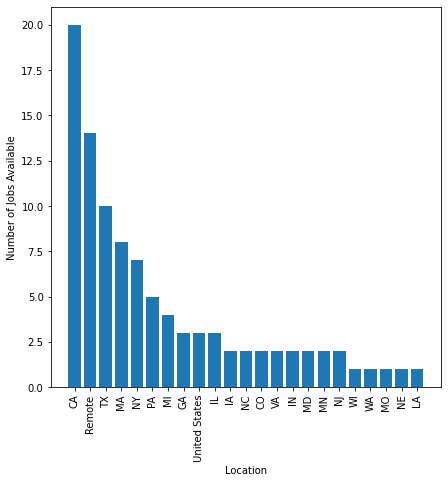

In [ ]:
geographic_locations = {}
mapping = us.states.mapping('abbr', 'name')
mapping = dict([(value,key) for key,value in mapping.items()])
for location in data["Location"]:
    state = re.search(r'[A-Z][A-Z]', location)
    #extract the state abbreviation from each location if it's included
    if state != None:
        state_abbrev = location[state.start():state.end()]
        if state_abbrev in geographic_locations:
            geographic_locations[state_abbrev] += 1
        else:
            geographic_locations[state_abbrev] = 1
    else:
        value = location
        if location in mapping: 
            value = mapping[location]
        if value in geographic_locations:
            geographic_locations[value] += 1
        else:
            geographic_locations[value] = 1 
geographic_locations = dict(sorted(geographic_locations.items(), 
                                   key = lambda x:x[1], reverse = True))
plt.figure(figsize = (7, 7))
plt.bar(geographic_locations.keys(), geographic_locations.values())
plt.xticks(rotation=90)
plt.ylabel("Number of Jobs Available")
plt.xlabel("Location")
plt.show()

In [ ]:
import time
from string import punctuation
import nltk
nltk.download('averaged_perceptron_tagger') #tags words with part of speech
nltk.download('punkt') #sentence tokenizer 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Gathering text from job descriptions**
<br>
Now, we can access the job links that we retrieved earlier and gather the job descriptions from each link. We can save the words in a list. In between each step of retrieving a new link, we will pause the program for 1 second. This is to space out our requests so we do not get hit with an hCaptcha. An hCaptcha was previously encountered when testing the code. *This step will take approximately 3 mins and 4 seconds (time recorded during testing).*

After this step, we are done with our ChromeDriver and can close it by calling `driver.quit()`.

In [ ]:
job_descriptions = []
for posting in job_links:
    time.sleep(1) #pause program for 1 second
    driver.get(posting)
    job_description = driver.find_element_by_xpath(
        '//div[@class="jobsearch-jobDescriptionText"]').text
    text = job_description.split()
    job_descriptions.extend(text)
driver.quit() 

**Processing the text**
<br>
Parse the words by converting them to lowercase and stripping leading and trailing punctuation. The words at the end of a sentence include trailing punctuation. Place the words in a string which can be used with the `nltk` package. 

In [ ]:
collection = {}
parsed_job_descriptions = []
for word in job_descriptions:
    parsed_job_descriptions.append(word.lower().strip(punctuation))
text = ' '.join(parsed_job_descriptions)

The `nltk` (Natural Language Toolkit) package allows us to identify the part of speech each word in a string belongs to. `nltk.word_tokenize` splits the string. `nltk.pos_tag` returns a list of tuples, where the first element is the word and the second element is the part of speech tag. We want to keep all words which are nouns, and that contain more than one letter. We select nouns because nouns include the skills required for a job. These are the words which are of interest to us. Nouns have the following tags:
- *NN* noun, singular
- *NNS* noun, plural
- *NNP* proper noun, singular
- *NNPS* proper noun, plural

In [ ]:
tokens = nltk.word_tokenize(text)
labeled_words = nltk.pos_tag(tokens)
saved_text = []
for pair in labeled_words:
    if pair[1].startswith('N') and len(pair[0]) > 1:
        saved_text.append(pair[0])
new_text = ' '.join(saved_text)

In [ ]:
from wordcloud import WordCloud

**Creating a wordcloud**
<br>
Now, we can use our processed string to create a `wordcloud` of the frequently occurring words in the job descriptions we retrieved. This is a neat way to visualize our results. We can select the background color and dimensions of our wordcloud. Another parameter which is commonly passed to WordCloud is stopwords, a set of strings to eliminate. The built-in `STOPWORDS` list is used by default. Since our string only contains nouns, we omit stopwords as a parameter. 

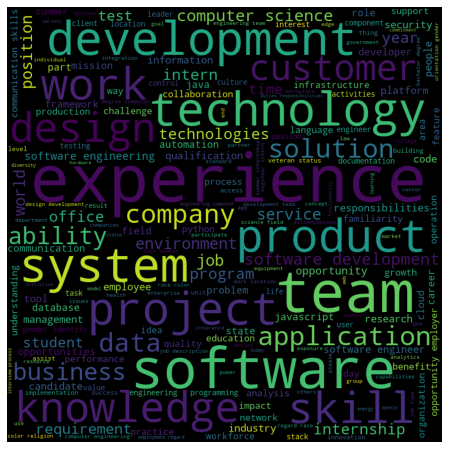

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='black').generate(new_text)
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# More on ChromeDriver
I originally created this tutorial in a Jupyter Notebook, and installed the chromedriver.exe file on my computer to run ChromeDriver. Since Colab provides a simpler way to use ChromeDriver without requiring the user to download the executable and move it to the correct folder on their computer, I opted for this method. 

**For Mac Users:**
<br>
If you use Chrome and are interested in installing ChromeDriver on your computer, visit https://chromedriver.chromium.org/. Once the correct version of ChromeDriver is installed on your computer in the correct location (it should be in usr/local/bin as noted below), replace:


```
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
```

with

```
path = '/usr/local/bin/chromedriver'
driver = webdriver.Chrome(path)
```
and remove


```
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
```

After running the code, a new Chrome window will open with the following message at the top: "Chrome is being controlled by automated test software." You will be able to view the ChromeDriver in action.




#Summary and references 
This tutorial provides an overview of scraping a webpage using Selenium and different ways to visualize the data. For more information on the topics discussed in this tutorial, visit the links shown below. Thank you for reading!




1. https://www.w3schools.com/xml/xpath_syntax.asp
2. https://www.geeksforgeeks.org/click-element-method-selenium-python/
3. https://www.geeksforgeeks.org/get_attribute-element-method-selenium-python/
4. https://selenium-python.readthedocs.io/getting-started.html
5. https://selenium-python.readthedocs.io/locating-elements.html
6. https://selenium-python.readthedocs.io/waits.html
7. https://pypi.org/project/us/
8. https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/
9. https://www.geeksforgeeks.org/generating-word-cloud-python/
10. https://towardsdatascience.com/web-scraping-job-postings-from-indeed-com-using-selenium-5ae58d155daf
11. https://www.analyticsvidhya.com/blog/2020/10/web-scraping-selenium-in-python/